# One-Stop Notebook for CSRNet Dataset Preparation

For Model Training workflow, this is Step 1.

## 0.0 RGBhr to RGB renaming

some files end with RGBhr and some end with RGB. Its a pain, and i still have some rules to account for it in other notebooks. But here, we remove it entirely.

In [2]:
import os

In [31]:
# Define the folder path
input_images_folder = r'D:\AI\CSRNet\CSRNet-pytorch\dataset\images'

for file_name in os.listdir(input_images_folder):
    # Check if the file ends with 'RGBhr.png'
    if file_name.endswith('RGBhr.png'):
        
        old_file_path = os.path.join(input_images_folder, file_name)
        new_file_name = file_name.replace('RGBhr.png', 'RGB.png')
        new_file_path = os.path.join(input_images_folder, new_file_name)
        
        # Rename the file
        os.rename(old_file_path, new_file_path)
        print(f"Renamed: {file_name} to {new_file_name}")

print("Renaming complete for images ending in 'RGBhr.png'.")

Renaming complete for images ending in 'RGBhr.png'.


## 1.0 Image checking and Resize

### Image Dimension Grouping and Tracker

In [4]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

In [5]:
input_images_folder = r'D:\AI\CSRNet\CSRNet-pytorch\dataset\images'
input_annotations_folder = r'D:\AI\CSRNet\CSRNet-pytorch\dataset\annotations'
output_images_folder = r'D:\AI\CSRNet\CSRNet-pytorch\dataset\train\images'
output_annotations_folder = r'D:\AI\CSRNet\CSRNet-pytorch\dataset\train\annotations'

In [6]:
# Ensure output directories exist
os.makedirs(output_images_folder, exist_ok=True)
os.makedirs(output_annotations_folder, exist_ok=True)

In [7]:
# This checks the file dimensions of all images in the input folder and returns the count of each dimension group
image_sizes = []
count = {}
for root, dirs, files in os.walk(input_images_folder):
   for file in files:
       img = Image.open(os.path.join(root, file))
       width, height = img.size
       image_sizes.append((width,height))
       
       if (width, height) not in count:
           count[(width, height)] = 0
           
       count[(width, height)] += 1
   
for k, v in sorted(count.items()):
   print('%sx%s: %d' % (k[::-1] + (v,)))

202x308: 1120
373x548: 967


### 1.1 Prep for CSRNet
This resizes the images, and scales the annotations at the same time.

In [13]:
def preprocess_image_and_annotations(image_path, annotation_path, output_image_path, output_annotation_path, target_size=(224, 224)):
    # Open the image
    image = Image.open(image_path)
    original_width, original_height = image.size
    
    # Resize image while maintaining aspect ratio
    image.thumbnail(target_size, Image.Resampling.LANCZOS)
    resized_width, resized_height = image.size
    
    # Calculate padding to reach target size without distortion
    delta_w = target_size[0] - resized_width
    delta_h = target_size[1] - resized_height
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
    image = ImageOps.expand(image, padding)
    
    # Save the processed image to the output path
    image.save(output_image_path)
    
    # Process annotation coordinates
    annotations = pd.read_csv(annotation_path)
    if 'c-x' in annotations.columns and 'c-y' in annotations.columns:
        # Scale coordinates based on resizing
        annotations['c-x'] = annotations['c-x'] * (resized_width / original_width) + padding[0]
        annotations['c-y'] = annotations['c-y'] * (resized_height / original_height) + padding[1]
    
    # Save the updated annotations
    annotations.to_csv(output_annotation_path, index=False)
    print(f"Processed and saved image to {output_image_path} and annotations to {output_annotation_path}")

In [14]:
# Process each image and its corresponding annotation
for file_name in os.listdir(input_images_folder):
    if file_name.endswith('.png'):
        input_image_path = os.path.join(input_images_folder, file_name)
        output_image_path = os.path.join(output_images_folder, file_name)
        
        annotation_file_name = file_name.replace('.png', '.csv')
        input_annotation_path = os.path.join(input_annotations_folder, annotation_file_name)
        output_annotation_path = os.path.join(output_annotations_folder, annotation_file_name)
        
        if os.path.exists(input_annotation_path):
            preprocess_image_and_annotations(input_image_path, input_annotation_path, output_image_path, output_annotation_path)

Processed and saved image to D:\AI\CSRNet\CSRNet-pytorch\dataset\train\images\20130320T004348.182606.Cam6_54.png and annotations to D:\AI\CSRNet\CSRNet-pytorch\dataset\train\annotations\20130320T004348.182606.Cam6_54.csv
Processed and saved image to D:\AI\CSRNet\CSRNet-pytorch\dataset\train\images\20130320T004348.754118.Cam6_13.png and annotations to D:\AI\CSRNet\CSRNet-pytorch\dataset\train\annotations\20130320T004348.754118.Cam6_13.csv
Processed and saved image to D:\AI\CSRNet\CSRNet-pytorch\dataset\train\images\20130320T004349.135000.Cam6_11.png and annotations to D:\AI\CSRNet\CSRNet-pytorch\dataset\train\annotations\20130320T004349.135000.Cam6_11.csv
Processed and saved image to D:\AI\CSRNet\CSRNet-pytorch\dataset\train\images\20130320T004349.516008.Cam6_43.png and annotations to D:\AI\CSRNet\CSRNet-pytorch\dataset\train\annotations\20130320T004349.516008.Cam6_43.csv
Processed and saved image to D:\AI\CSRNet\CSRNet-pytorch\dataset\train\images\20130320T004351.039789.Cam6_32.png and

### 1.2 Sanity check for output files

In [15]:
# This checks the file dimensions of all images in the output folder, scaled.
image_sizes = []
count = {}
for root, dirs, files in os.walk(output_images_folder):
   for file in files:
       img = Image.open(os.path.join(root, file))
       width, height = img.size
       image_sizes.append((width,height))
       
       if (width, height) not in count:
           count[(width, height)] = 0
           
       count[(width, height)] += 1
   
for k, v in sorted(count.items()):
   print('%sx%s: %d' % (k[::-1] + (v,)))

224x224: 2087


In [16]:
# Validation Step: Randomly select an image and display it with annotations plotted
def validate_random_image():
    # List of processed images
    processed_images = [f for f in os.listdir(output_images_folder) if f.endswith('.png')]
    if not processed_images:
        print("No images found for validation.")
        return

    # Choose a random image
    random_image_name = random.choice(processed_images)
    random_image_path = os.path.join(output_images_folder, random_image_name)
    random_annotation_path = os.path.join(output_annotations_folder, random_image_name.replace('.png', '.csv'))
    
    # Load the image and annotations
    image = Image.open(random_image_path)
    annotations = pd.read_csv(random_annotation_path)
    
    # Plot the image with annotations
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.scatter(annotations['c-x'], annotations['c-y'], color='red', s=10, marker='o')
    plt.title(f"Validation: {random_image_name}")
    plt.show()

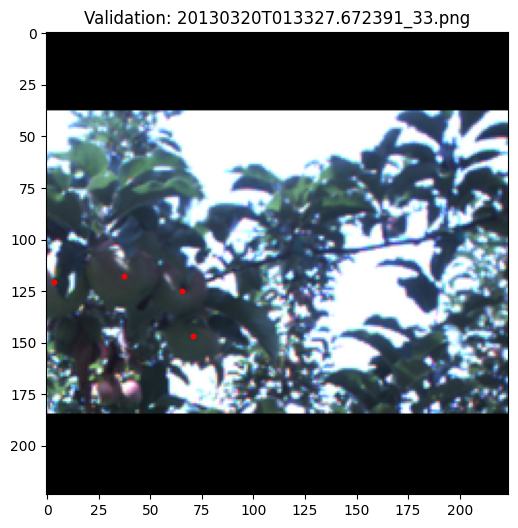

In [20]:
validate_random_image()

## 2.0 Annotation Checking for Resized Images

This is now handled in the same function as the image scaling.

## 3.0 80:20 split on adjusted files and annotations

In [22]:
import os
import shutil
import random

In [23]:
train_images_folder = r'D:\AI\CSRNet\CSRNet-pytorch\dataset\train\images'
test_images_folder = r'D:\AI\CSRNet\CSRNet-pytorch\dataset\test\images'
train_annotations_folder = r'D:\AI\CSRNet\CSRNet-pytorch\dataset\train\annotations'
test_annotations_folder = r'D:\AI\CSRNet\CSRNet-pytorch\dataset\test\annotations'

In [25]:
os.makedirs(test_images_folder, exist_ok=True)
os.makedirs(test_annotations_folder, exist_ok=True)

In [26]:
# Get list of image files in the training images folder
image_files = [f for f in os.listdir(train_images_folder) if f.endswith('.png')]

# Determine 20% of the images at random
test_size = int(0.2 * len(image_files))
test_images = random.sample(image_files, test_size)

In [27]:
# Move selected images and their corresponding annotations
for image_file in test_images:
    # Define full paths for images
    source_image_path = os.path.join(train_images_folder, image_file)
    destination_image_path = os.path.join(test_images_folder, image_file)
    
    # Define corresponding annotation file name and paths
    annotation_file = image_file.replace('.png', '.csv')
    source_annotation_path = os.path.join(train_annotations_folder, annotation_file)
    destination_annotation_path = os.path.join(test_annotations_folder, annotation_file)
    
    # Check if both image and annotation exist, move only if both are present
    if os.path.exists(source_image_path) and os.path.exists(source_annotation_path):
        shutil.move(source_image_path, destination_image_path)
        shutil.move(source_annotation_path, destination_annotation_path)
    else:
        print(f"Warning: Skipping {image_file} as its corresponding annotation file is missing.")

print("Dataset split complete. Images and annotations have been moved to the test folder.")

Dataset split complete. Images and annotations have been moved to the test folder.


### Did that work?

In [28]:
def check_corresponding_files(images_folder, annotations_folder):
    # Get list of images and annotations
    image_files = [f for f in os.listdir(images_folder) if f.endswith('.png')]
    annotation_files = [f for f in os.listdir(annotations_folder) if f.endswith('.csv')]

    # Remove extensions to compare just the base names
    image_basenames = {os.path.splitext(f)[0] for f in image_files}
    annotation_basenames = {os.path.splitext(f)[0] for f in annotation_files}

    # Find mismatches
    missing_annotations = image_basenames - annotation_basenames
    extra_annotations = annotation_basenames - image_basenames

    # Report results with counts
    print(f"\nChecking folder: {images_folder}")
    if missing_annotations:
        print(f"Missing annotations for {len(missing_annotations)} images: {missing_annotations}")
    else:
        print("All images have corresponding annotations.")
    
    if extra_annotations:
        print(f"Extra annotations without images for {len(extra_annotations)} annotations: {extra_annotations}")
    else:
        print("No extra annotations without corresponding images.")
    
    return len(missing_annotations), len(extra_annotations)

In [29]:
# Check train and test folders
print("Checking training folder consistency:")
train_missing, train_extra = check_corresponding_files(train_images_folder, train_annotations_folder)

print("\nChecking testing folder consistency:")
test_missing, test_extra = check_corresponding_files(test_images_folder, test_annotations_folder)

Checking training folder consistency:

Checking folder: D:\AI\CSRNet\CSRNet-pytorch\dataset\train\images
All images have corresponding annotations.
No extra annotations without corresponding images.

Checking testing folder consistency:

Checking folder: D:\AI\CSRNet\CSRNet-pytorch\dataset\test\images
All images have corresponding annotations.
No extra annotations without corresponding images.


In [30]:
# Summary
print("\nSummary:")
print(f"Train folder - Missing annotations: {train_missing}, Extra annotations: {train_extra}")
print(f"Test folder - Missing annotations: {test_missing}, Extra annotations: {test_extra}")


Summary:
Train folder - Missing annotations: 0, Extra annotations: 0
Test folder - Missing annotations: 0, Extra annotations: 0


Now go to ```CSV_to_H5.ipynb```